In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cma

def load_results_dict(dir, filename):
    with open(dir+'/'+filename, 'rb') as f:
        results = pkl.load(f)
    return results

multitask = True
date = '2024-10-22'
    
fixed_name = '_multi_task_exp_weighed_'
    
dir = 'heterogeneity_results'
suffix = '_4k'
filenames = {
    'ddn': {
        'distributed': {
            'cluster': date + fixed_name + 'DDN_dist_decay_per_cluster' + suffix + '.p',
            'network': date + fixed_name + 'DDN_dist_decay_net_wide' + suffix + '.p'
        },
        'fixed': {
            'cluster': date + fixed_name + 'DDN_fixed_decay_per_cluster' + suffix + '.p',
            'network': date + fixed_name + 'DDN_fixed_decay_net_wide' + suffix + '.p',
        }
    },
    'esn': {
        'distributed': {
            'cluster': date + fixed_name + 'BL_dist_decay_per_cluster' + suffix + '.p',
            'network': date + fixed_name + 'BL_dist_decay_net_wide' + suffix + '.p',
        },
        'fixed': {
            'cluster': date + fixed_name + 'BL_fixed_decay_per_cluster' + suffix + '.p',
            'network': date + fixed_name + 'BL_fixed_decay_net_wide' + suffix + '.p',
        }
    }
}

In [2]:
results_dicts = {}
for factor_1 in filenames:
    results_dicts[factor_1] = {}
    for factor_2 in filenames[factor_1]:
        results_dicts[factor_1][factor_2] = {}
        for factor_3 in filenames[factor_1][factor_2]:
            print('loading: ' + filenames[factor_1][factor_2][factor_3])
            results_dicts[factor_1][factor_2][factor_3] = load_results_dict(dir, filenames[factor_1][factor_2][factor_3])

loading: 2024-10-22_multi_task_exp_weighed_DDN_dist_decay_per_cluster_4k.p
loading: 2024-10-22_multi_task_exp_weighed_DDN_dist_decay_net_wide_4k.p
loading: 2024-10-22_multi_task_exp_weighed_DDN_fixed_decay_per_cluster_4k.p
loading: 2024-10-22_multi_task_exp_weighed_DDN_fixed_decay_net_wide_4k.p
loading: 2024-10-22_multi_task_exp_weighed_BL_dist_decay_per_cluster_4k.p
loading: 2024-10-22_multi_task_exp_weighed_BL_dist_decay_net_wide_4k.p
loading: 2024-10-22_multi_task_exp_weighed_BL_fixed_decay_per_cluster_4k.p
loading: 2024-10-22_multi_task_exp_weighed_BL_fixed_decay_net_wide_4k.p


In [3]:
# dict keys example
print(results_dicts['ddn']['distributed']['cluster'].keys())

dict_keys(['validation performance', 'parameters', 'evolutionary strategy', 'cma stds', 'example net', 'data', 'alphas', 'start net'])


## Evolution 

In [4]:
def get_validation_throughout_evolution(dict, gen_max, populations=False, multitask=False):
    # Validation scores are saved in a matrix with dimensions:
    # generations x hyperparameter candidates x re-initializations x lag search grid
    if not multitask:
        all_scores = dict['validation performance'][:gen_max, :, :, :]
    else:
        all_scores = dict['validation performance'][:gen_max, :, :, :, :]
    # from the lag search grid we select the best score (lowest NRMSE), since this was the best 
    # performing readout model
    best_lag_scores = np.min(all_scores, axis=-1)
    
    if multitask:
        # from the tasks, we select the average
        # best_lag_scores = best_lag_scores[:, :, :, 0]**2
        best_lag_scores = np.mean(best_lag_scores, axis=-1)
    
    # from the re-initializations from the same hyperparameter set/candidate, we take the average
    best_candidate_scores = np.mean(best_lag_scores, axis=-1)
    
    if populations:
        return best_candidate_scores
    
    # from the population of hyperparameter candidates, we select the best candidate
    best_gen_scores = np.min(best_candidate_scores, axis=-1)
    return best_gen_scores

In [40]:
gen_max = 130
val_scores = {}
for factor_1 in results_dicts:
    val_scores[factor_1] = {}
    for factor_2 in results_dicts[factor_1]:
        val_scores[factor_1][factor_2] = {}
        for factor_3 in results_dicts[factor_1][factor_2]:
            val_scores[factor_1][factor_2][factor_3] = get_validation_throughout_evolution(results_dicts[factor_1][factor_2][factor_3], gen_max, multitask=multitask)

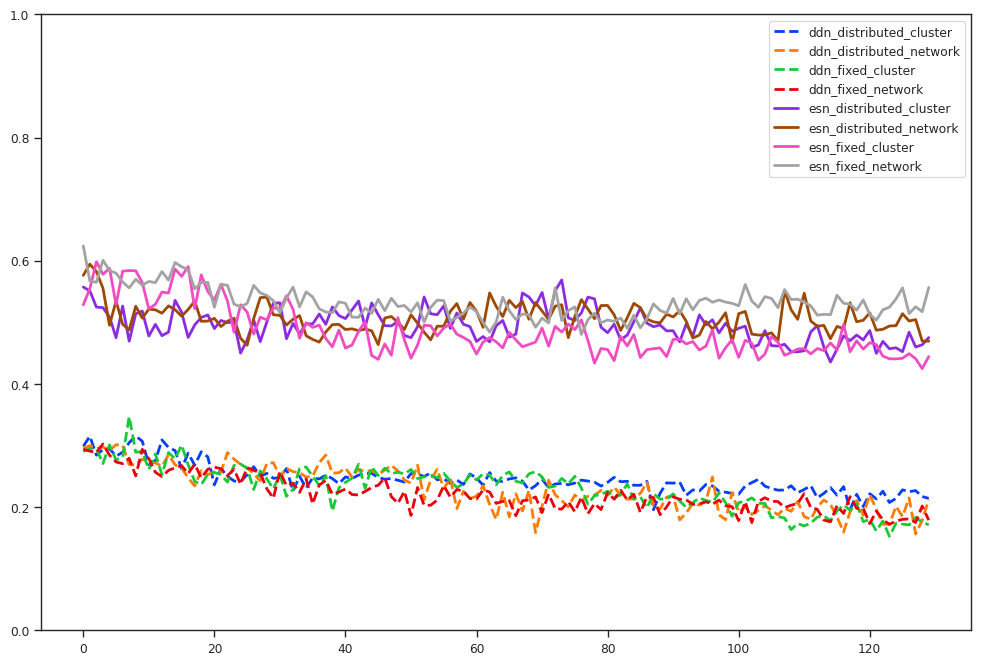

In [41]:
sns.set_theme(style="ticks", font_scale=1, palette='bright', context='paper')

plt.figure(figsize=(12,8))
gen_start = 0
gen_end = gen_max
for factor_1 in val_scores:
    for factor_2 in val_scores[factor_1]:
        for factor_3 in val_scores[factor_1][factor_2]:
            line = '-'
            if factor_1 == 'ddn':
                line = '--'
            plt.plot(val_scores[factor_1][factor_2][factor_3][gen_start:gen_end], label=factor_1 + '_' + factor_2 + '_' + factor_3, linestyle=line, linewidth=2)

plt.ylim(0, 1)         
plt.legend()

In [42]:
def get_best_candidate(dict, gen_max, multitask=False):
    best_gen_scores = get_validation_throughout_evolution(dict, gen_max, multitask=multitask)   
    best_candidates = get_validation_throughout_evolution(dict, gen_max, populations=True, multitask=multitask)
    best_gen_ind = np.argmin(best_gen_scores)
    best_candidate_ind = np.argmin(best_candidates[best_gen_ind])
    return best_gen_ind, best_candidate_ind
    
def sample_best_net(dict, n, gen_max, multitask=False):
    gen, ind = get_best_candidate(dict, gen_max, multitask=multitask)
    print(gen, ind)
    start_net = dict['example net']
    best_parameter_set = dict['parameters'][gen, ind, :]
    best_nets = []
    for i in range(n):
        best_net = start_net.get_new_network_from_serialized(best_parameter_set)
        best_nets.append(best_net)
    return best_nets


In [21]:
from simulator import NetworkSimulator
# Example on how to analyse single nets

example_results_dict = results_dicts['ddn']['distributed']['cluster']
print(example_results_dict.keys())
print(example_results_dict['data']['validation'].keys())

nets = sample_best_net(example_results_dict, 5, 40, multitask=True)
print(nets)
net = nets[0]
sim = NetworkSimulator(net)
# inputs = np.random.uniform(0, .5, size=(1000,))
inputs = np.zeros(shape=(1000,))

for i in np.arange(25, 1000, 25):
    inputs[i] = 50
    
# sim.visualize(inputs)
state_space = sim.get_network_data(inputs)
print(state_space.shape)

dict_keys(['validation performance', 'parameters', 'evolutionary strategy', 'cma stds', 'example net', 'data', 'alphas', 'start net'])
dict_keys(['inputs', 'labels'])
32 9
[<populations.FlexiblePopulation object at 0x7f6fa14413d0>, <populations.FlexiblePopulation object at 0x7f6fa00688b0>, <populations.FlexiblePopulation object at 0x7f6fa00d0fd0>, <populations.FlexiblePopulation object at 0x7f6fa004d700>, <populations.FlexiblePopulation object at 0x7f6fa14bb190>]
(199, 1000)


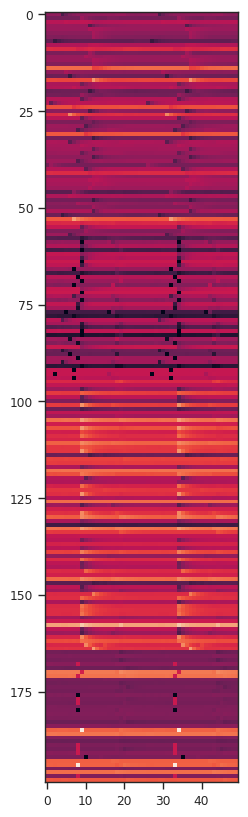

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(state_space[:, 400:450])

In [60]:
best_lags = []
lags_are_different = 0
total_inds = 0 
for factor_2 in results_dicts['ddn']:
    for factor_3 in results_dicts['ddn'][factor_2]:
        for gen in range(0, gen_max):
            for ind in range(0, 20):
                total_inds += 1
                val_score = results_dicts['ddn'][factor_2][factor_3]['validation performance'][gen, ind]
                best_lag_cand = np.argmin(val_score, axis=-1)
                if len(np.unique(best_lag_cand[:, 1])) > 1:
                    print(best_lag_cand[:, 1])
        # gen, ind = get_best_candidate(results_dicts['ddn'][factor_2][factor_3], gen_max, multitask=multitask)
        # val_score = results_dicts['ddn'][factor_2][factor_3]['validation performance'][gen, ind]
        # print(gen, ind)
        # plt.plot(val_score[1, 1, :])


[1 2 0 0 0]
[8 3 2 0 3]
[1 0 6 2 8]
[1 0 0 0 0]
[3 1 0 3 0]
[6 6 4 3 3]
[0 0 1 0 0]
[0 2 4 0 1]
[1 0 0 0 1]
[0 2 2 2 0]
[2 2 1 3 2]
[0 5 0 2 4]
[1 2 2 4 7]
[6 6 6 7 6]
[3 8 3 8 4]
[6 6 6 6 4]
[3 2 2 2 2]
[0 0 1 0 0]
[1 1 4 9 5]
[1 2 2 1 1]
[3 6 2 2 3]
[2 1 4 0 2]
[ 6  5  5 14 14]
[0 1 3 2 2]
[2 2 1 4 2]
[1 1 0 0 0]
[0 0 1 0 0]
[0 0 7 0 0]
[2 2 2 3 2]
[ 1  2  2 10  0]
[1 0 0 0 0]
[4 1 1 0 4]
[6 6 4 6 4]
[0 0 1 0 0]
[0 0 0 1 0]
[1 0 0 0 0]
[0 3 1 0 1]
[0 0 2 1 0]
[1 2 4 2 1]
[ 0  1 12  3  0]
[0 1 1 1 0]
[3 0 1 1 0]
[6 3 4 3 8]
[1 1 4 1 1]
[0 0 2 1 2]
[4 3 3 3 4]
[4 2 6 2 2]
[2 3 1 2 3]
[0 1 6 2 0]
[0 0 0 1 0]
[ 3 14 14 14 14]
[0 2 2 3 1]
[6 0 7 0 4]
[6 2 3 6 2]
[3 2 3 2 6]
[1 0 0 0 1]
[2 1 2 0 0]
[0 0 3 0 0]
[1 0 0 2 1]
[9 3 1 2 2]
[7 4 2 3 3]
[0 0 0 2 2]
[0 1 3 3 2]
[1 1 1 1 0]
[1 1 2 1 1]
[5 7 6 6 5]
[3 4 0 1 3]
[4 0 0 0 2]
[0 0 2 1 0]
[1 1 0 3 0]
[0 0 1 0 0]
[0 2 2 0 0]
[2 1 2 1 4]
[3 1 1 4 3]
[0 0 1 0 2]
[2 1 0 3 3]
[3 4 7 3 3]
[1 1 1 0 1]
[4 0 0 0 0]
[0 0 1 2 0]
[6 6 5 6 5]
[4 3 3 4

In [23]:
final_nets = {}
for factor_1 in results_dicts:
    final_nets[factor_1] = {}
    for factor_2 in results_dicts[factor_1]:
        final_nets[factor_1][factor_2] = {}
        for factor_3 in results_dicts[factor_1][factor_2]:
            best_nets = sample_best_net(results_dicts[factor_1][factor_2][factor_3], 15, gen_max, multitask=multitask)
            final_nets[factor_1][factor_2][factor_3] = best_nets

87 17
127 14
123 19
123 1
114 10
25 11
128 11
76 18


In [24]:
from utils import eval_candidate_lag_gridsearch_NARMA, createNARMA30, createNARMA10, eval_candidate_lag_gridsearch_NARMA_multitask, inputs2NARMA

if multitask:
    inputs_train, labels_train_10 = createNARMA10(8000)
    inputs_val, labels_val_10 = createNARMA10(4000)

    labels_train_30 = inputs2NARMA(inputs_train, system_order=30, coef=[.2, .04, 1.5, .001])
    labels_val_30 = inputs2NARMA(inputs_val, system_order=30, coef=[.2, .04, 1.5, .001])
else:
    data_train = np.array(createNARMA30(8000)).reshape((2, 8000))
    data_test = np.array(createNARMA30(4000)).reshape((2, 4000))
alphas = [10e-7, 10e-5, 10e-3]

test_results = {
    'Test NRMSE' : [],
    'Network type': [],
    'Distribution heterogeneity': [],
    'Cluster heterogeneity': []
}

def write(dict, score, net_type, f1, f2):
    dict['Test NRMSE'].append(score)
    dict['Network type'].append(net_type)
    dict['Distribution heterogeneity'].append(f1)
    dict['Cluster heterogeneity'].append(f2)
    
for factor_1 in final_nets:
    for factor_2 in final_nets[factor_1]:
        for factor_3 in final_nets[factor_1][factor_2]:
            for net in final_nets[factor_1][factor_2][factor_3]:
                if not multitask:
                    _, val_scores_lags, _ = eval_candidate_lag_gridsearch_NARMA(net, data_train, data_test,alphas=alphas)
                    best_lag_score = np.min(val_scores_lags)
                    write(test_results, best_lag_score, factor_1, factor_2, factor_3)
                else:
                    _, val_score_per_task, _ = eval_candidate_lag_gridsearch_NARMA_multitask(net,inputs_train, inputs_val, [labels_train_10, labels_train_30], [labels_val_10, labels_val_30], alphas=alphas)
                    val_score_per_task = np.array(val_score_per_task)
                    best_lag_score = np.min(val_score_per_task, axis=-1)
                    task_average_score = np.mean(best_lag_score, axis=-1)
                    write(test_results, task_average_score, factor_1, factor_2, factor_3)
                

In [25]:
test_df = pd.DataFrame.from_dict(test_results)
test_df_esn = test_df[test_df['Network type'] == 'esn']
test_df_ddn = test_df[test_df['Network type'] == 'ddn']
test_df_esn.head()

,Test NRMSE,Network type,Distribution heterogeneity,Cluster heterogeneity
60,0.431692,esn,distributed,cluster
61,0.454027,esn,distributed,cluster
62,0.431553,esn,distributed,cluster
63,0.428890,esn,distributed,cluster
64,0.450549,esn,distributed,cluster


<AxesSubplot: xlabel='Distribution heterogeneity', ylabel='Test NRMSE'>

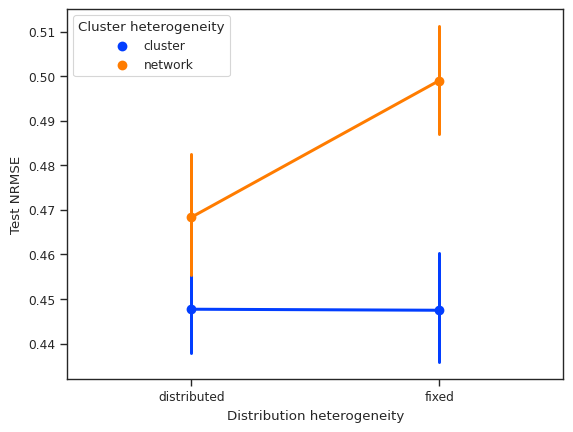

In [26]:
sns.pointplot(test_df_esn, x='Distribution heterogeneity', y='Test NRMSE', hue='Cluster heterogeneity',)

<AxesSubplot: xlabel='Distribution heterogeneity', ylabel='Test NRMSE'>

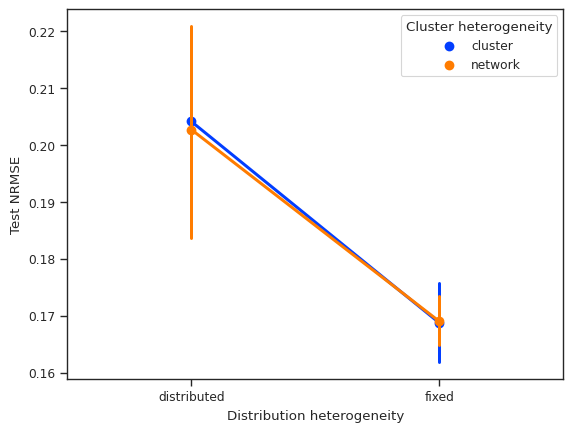

In [27]:
sns.pointplot(test_df_ddn, x='Distribution heterogeneity', y='Test NRMSE', hue='Cluster heterogeneity',)

## Heterogeneity Measure

## Visualisations of actual heterogeneity and parameter spread


In [32]:
def binned_entropy(parameters, bins=20):
    parameters = np.reshape(parameters, (np.product(parameters.shape),))
    freqs = np.histogram(parameters, bins=bins)
    total = np.sum(freqs[0])
    entropy = 0
    for freq in freqs[0]:
        if freq != 0:
            p = freq / total
            entropy += p * np.log(p)
    return -entropy


0.6324651567910983
0.6318535696488647
0.601637159347407
0.6088900274624263
0.6084797702233677
0.6350483021758656
0.6660113258004918
0.646723234253171
0.6134247240117431
0.5697933963367859
0.6893112240710404
0.6143862688002446
0.6191657109823605
0.6093902138063898
0.6356787442614227


KeyboardInterrupt: 

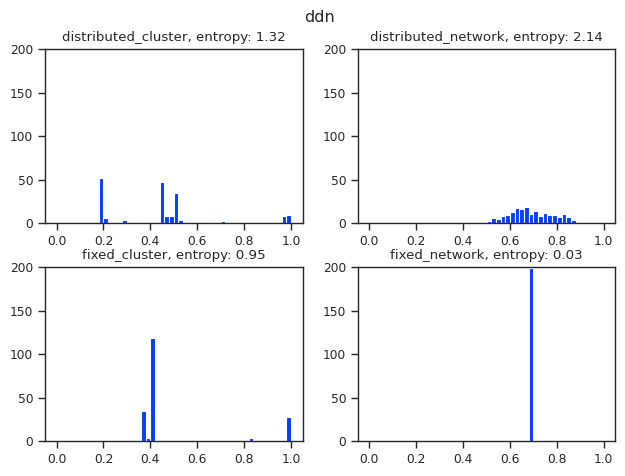

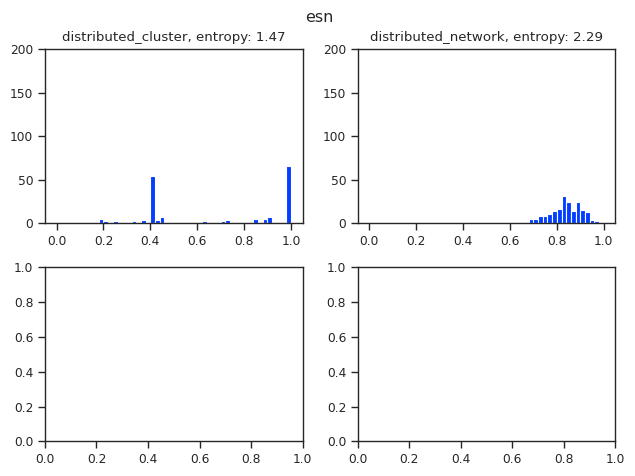

In [34]:
bins = 50
for factor_1 in final_nets:
    fig, ax = plt.subplots(2, 2)
    fig.suptitle(factor_1)
    plt.tight_layout()
    for i, factor_2 in enumerate(final_nets[factor_1]):
        for j, factor_3 in enumerate(final_nets[factor_1][factor_2]):
            decays_sampled = []
            entropy_sampled = []
            for net in final_nets[factor_1][factor_2][factor_3]:
                decays_sampled.append(net.decay)
                entropy = binned_entropy(net.decay, bins=bins)
                entropy_sampled.append(entropy)
            decays_av = np.mean(decays_sampled, axis=0)
            entropy_av = np.mean(entropy_sampled, axis=0)
            ax[i, j].set_title(factor_2 + '_' + factor_3 + ', entropy: ' + str(np.round(entropy_av, 2)))
            ax[i, j].hist(decays_av, bins=bins, range=(0,1))
            ax[i, j].set_ylim(0, 200)


In [269]:
bins = 40

data_train = np.array(createNARMA30(8000)).reshape((2, 8000))
data_test = np.array(createNARMA30(4000)).reshape((2, 4000))

alphas = [10e-7, 10e-5, 10e-3]
    
test_results_het = {
    'Test NRMSE' : [],
    'Binned Entropy': [],
    'Network type': [],
    'Distribution heterogeneity': [],
    'Cluster heterogeneity': []
}

def write(dict, score, ent, net_type, f1, f2):
    dict['Test NRMSE'].append(score)
    dict['Binned Entropy'].append(ent)
    dict['Network type'].append(net_type)
    dict['Distribution heterogeneity'].append(f1)
    dict['Cluster heterogeneity'].append(f2)
    
for factor_1 in final_nets:
    for factor_2 in final_nets[factor_1]:
        for factor_3 in final_nets[factor_1][factor_2]:
            for net in final_nets[factor_1][factor_2][factor_3]:
                _, val_scores_lags, _ = eval_candidate_lag_gridsearch_NARMA(net, data_train, data_test,alphas=alphas)
                best_lag_score = np.min(val_scores_lags)
                net_heterogeneity = binned_entropy(net.decay, bins=bins)
                write(test_results_het, net_heterogeneity, best_lag_score, factor_1, factor_2, factor_3)

In [270]:
test_df = pd.DataFrame.from_dict(test_results_het)
test_df_esn = test_df[test_df['Network type'] == 'esn']
test_df_ddn = test_df[test_df['Network type'] == 'ddn']
test_df_esn.head()

,Test NRMSE,Binned Entropy,Network type,Distribution heterogeneity,Cluster heterogeneity
60,1.229133,0.663530,esn,distributed,cluster
61,1.125292,0.656782,esn,distributed,cluster
62,0.969077,0.629175,esn,distributed,cluster
63,0.912221,0.609971,esn,distributed,cluster
64,1.119658,0.667733,esn,distributed,cluster


(0.0, 1.0)

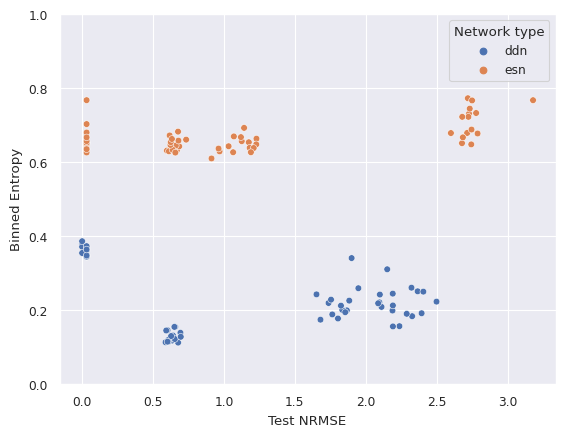

In [274]:
sns.scatterplot(test_df, y='Binned Entropy', x='Test NRMSE', hue='Network type')
plt.ylim(0, 1)